# Wildfire Binary Classifier Notebook (To make **predictions** by using our model checkpoint)

### Description

This notebook focuses on the **prediction** aspect of the **wildfire binary classifier model** built using a curated dataset from Kaggle. We acknowledge that for the sake of simplicity, this approach is used while acknowledging the initial attempt to build a custom dataset.

The main purpose of this notebook is to **demonstrate the model's ability to predict whether an area is at risk of wildfire based on a given satellite image**. The provided code allows for easy execution within a Google Colab environment.


## Install gdown library for downloading files

In [55]:
!pip install gdown

## Import libraries

In [56]:
import os
import torch.nn as nn
import torch
from torchvision import transforms
from PIL import Image

## Set 'cpu' as device

In [57]:
device = "cpu"

## Neural Network Model Architecture

In [58]:
class ConvBlock(nn.Module):

    def __init__(
            self,
            num_inp_channels: int,
            num_out_fmaps: int,
            kernel_size: int,
            pool_size: int = 2
    ) -> None:
        super().__init__()

        self.conv = nn.Conv2d(in_channels=num_inp_channels,
                              out_channels=num_out_fmaps,
                              kernel_size=(kernel_size, kernel_size),
                              bias=False)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool_2d = nn.MaxPool2d(kernel_size=(pool_size, pool_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_2d(self.relu(self.conv(x)))


class WildfireBinClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = ConvBlock(num_inp_channels=3, num_out_fmaps=8, kernel_size=2)
        self.conv2 = ConvBlock(num_inp_channels=8, num_out_fmaps=16, kernel_size=2)
        self.conv3 = ConvBlock(num_inp_channels=16, num_out_fmaps=32, kernel_size=2)

        # Defining the fully connected layers
        self.mlp = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features=56448, out_features=2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=2048, out_features=300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=300, out_features=2),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        bsz, nch, height, width = x.shape
        x = torch.reshape(x, (bsz, (nch * height * width)))
        y = self.mlp(x)
        return y


## Pre-processing transforms

In [59]:
def preprocessing_transforms(pil_image: Image.Image) -> torch.Tensor:
    # defining image transformations
    preprocess = transforms.Compose([
        transforms.Resize((350, 350)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])

    torch_image = preprocess(pil_image)
    try:
        assert isinstance(torch_image, torch.Tensor)
        assert list(torch_image.shape) == [3, 350, 350]
        print("preprocessing_transforms: OK")
    except Exception:
        raise Exception("Did you apply required transformations?")

    return torch_image

## Image prediction method

In [60]:
def predict_image(
        torch_image: torch.tensor,
        model: torch.nn.Module
):
    x = torch_image.to(device)  # move image to device
    x = x.unsqueeze(0)  # add batch dimension

    # Make a prediction
    output = model(x)
    output = torch.softmax(output, dim=1)  # Compute the softmax to get probabilities

    # labels = {'nowildfire': 0, 'wildfire': 1}
    class_names = ['nowildfire', 'wildfire']

    # Get the index of the class with the highest probability
    predicted_class_idx = torch.argmax(output).item()

    # Get the corresponding class name
    predicted_class_name = class_names[predicted_class_idx]

    print(f"Predicted class: {predicted_class_name}")

## Download model checkpoint

In [61]:
# Download my_model.pt file
!gdown --id 1NTI68QrPzffmW5Kbgzijs6Roxk_tdhG1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NTI68QrPzffmW5Kbgzijs6Roxk_tdhG1
From (redirected): https://drive.google.com/uc?id=1NTI68QrPzffmW5Kbgzijs6Roxk_tdhG1&confirm=t&uuid=4885a3cf-690b-4e96-9941-0bfcbac17081
To: /content/my_model.pt
100% 465M/465M [00:06<00:00, 75.1MB/s]


## Load the model

In [62]:
# Define the path to your saved model file
my_model = 'my_model.pt'

# Load the model state dictionary
state_dict = torch.load(my_model, map_location=torch.device(device))

# Reconstruct the model architecture
model = WildfireBinClassifier()
model.load_state_dict(state_dict)

<All keys matched successfully>

## Put model on Evaluation mode

In [63]:
# Ensure the model is in evaluation mode
model.eval()

WildfireBinClassifier(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool_2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool_2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool_2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=56448, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=300, bias=True)
    (5): ReLU()
    (6): Dropout(p=

## Download images to predict

In [64]:
!gdown --id 148dyNys8yKDjK8M3VE8h26ih9rTjo_M8
!gdown --id 1SC_yBaVtXP0Fq_gILyE5YGWKk3HYMjxH
!gdown --id 1XyXxBQYbN3_H_QgmNnA--sDdifu65epb
!gdown --id 1o86E1b0sBUYULGpewGtkXNCUWZpSgtCi

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=148dyNys8yKDjK8M3VE8h26ih9rTjo_M8
To: /content/test_w_-62.56176,51.29047.jpg
100% 31.5k/31.5k [00:00<00:00, 48.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SC_yBaVtXP0Fq_gILyE5YGWKk3HYMjxH
To: /content/test_nw_-73.58979,45.483765.jpg
100% 52.6k/52.6k [00:00<00:00, 61.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloadin

## Show images

In [65]:
# Import imshow
from matplotlib.pyplot import imshow

# Import numpy
import numpy as np

In [66]:
def show_image(pil_image):
    imshow(np.asarray(pil_image))

## Display Image 1

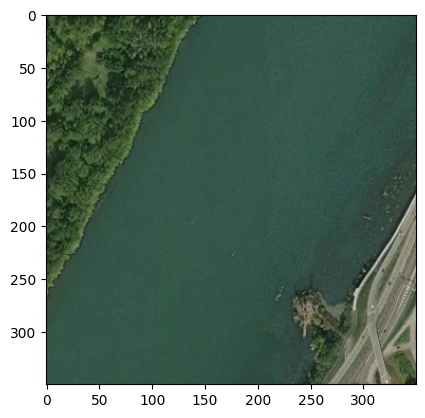

In [67]:
pil_image1 = Image.open("test_nw_-73.47513,45.58354.jpg")
show_image(pil_image1)

## Prediction expectation for Image 1 is **nowildfire** class.

## Display Image 2

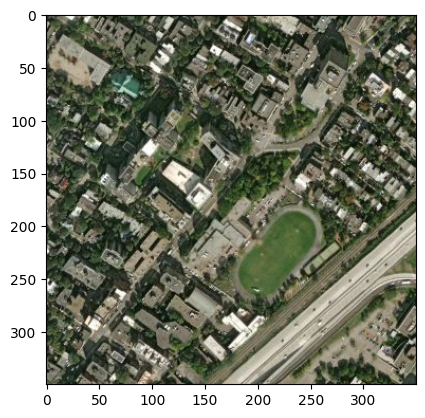

In [68]:
pil_image2 = Image.open("test_nw_-73.58979,45.483765.jpg")
show_image(pil_image2)

## Prediction expectation for Image 2 is **nowildfire** class.

## Display Image 3

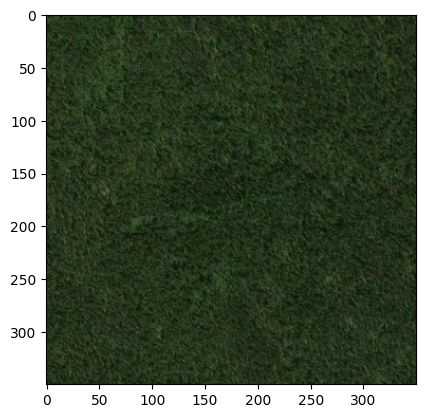

In [69]:
pil_image3 = Image.open("test_w_-62.56176,51.29047.jpg")
show_image(pil_image3)

## Prediction expectation for Image 3 is **wildfire** class.

## Display Image 4

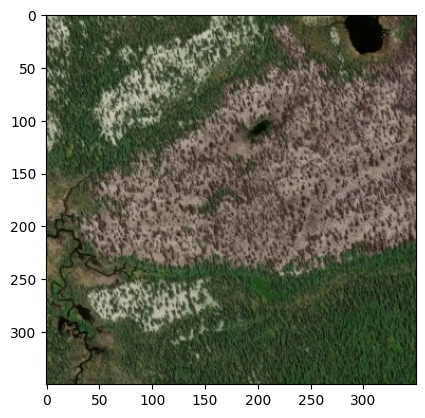

In [70]:
pil_image4 = Image.open("test_w_-63.3175,51.3397.jpg")
show_image(pil_image4)

## Prediction expectation for Image 4 is **wildfire** class.

## Apply preprocessing transformations to images

In [71]:
# Apply preprocessing transformations
tensor_img1 = preprocessing_transforms(pil_image1)
tensor_img2 = preprocessing_transforms(pil_image2)
tensor_img3 = preprocessing_transforms(pil_image3)
tensor_img4 = preprocessing_transforms(pil_image4)

preprocessing_transforms: OK
preprocessing_transforms: OK
preprocessing_transforms: OK
preprocessing_transforms: OK


## And finally... Make predictions of above images

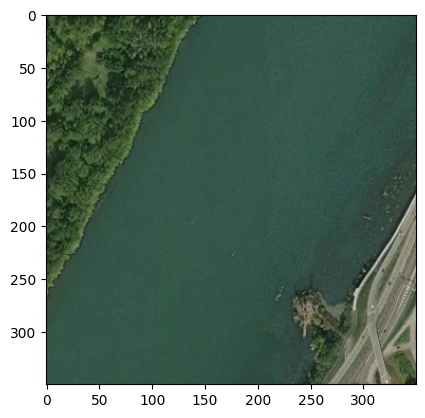

In [72]:
pil_image1 = Image.open("test_nw_-73.47513,45.58354.jpg")
show_image(pil_image1)

In [73]:
print(f"Image 1: {pil_image1}")
print(f"Expected: nowildfire")
predict_image(tensor_img1, model)

Image 1: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x350 at 0x7C4CC80F3970>
Expected: nowildfire
Predicted class: nowildfire


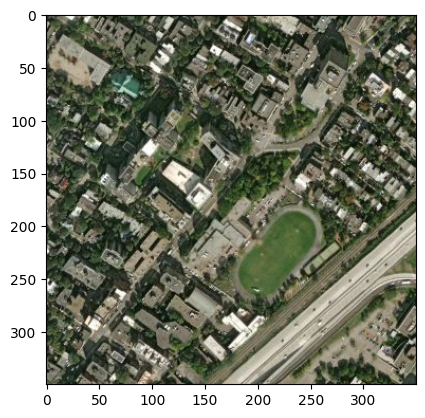

In [74]:
pil_image2 = Image.open("test_nw_-73.58979,45.483765.jpg")
show_image(pil_image2)

In [75]:
print(f"Image 2: {pil_image2}")
print(f"Expected: nowildfire")
predict_image(tensor_img2, model)

Image 2: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x350 at 0x7C4D01AAE3E0>
Expected: nowildfire
Predicted class: nowildfire


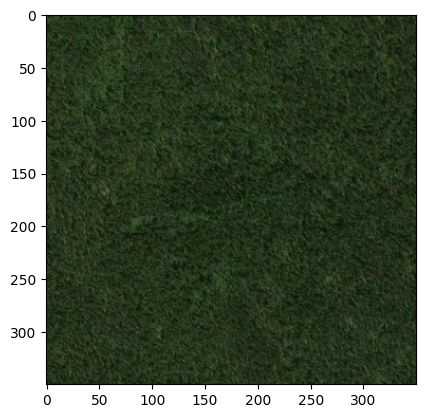

In [76]:
pil_image3 = Image.open("test_w_-62.56176,51.29047.jpg")
show_image(pil_image3)

In [77]:
print(f"Image 3: {pil_image3}")
print(f"Expected: wildfire")
predict_image(tensor_img3, model)

Image 3: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x350 at 0x7C4CC8016950>
Expected: wildfire
Predicted class: wildfire


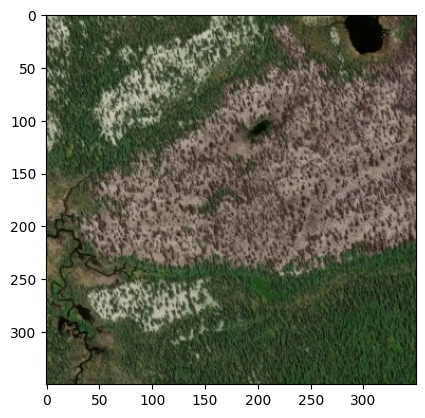

In [78]:
pil_image4 = Image.open("test_w_-63.3175,51.3397.jpg")
show_image(pil_image4)

In [79]:
print(f"Image 4: {pil_image4}")
print(f"Expected: wildfire")
predict_image(tensor_img4, model)

Image 4: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x350 at 0x7C4CC806CC10>
Expected: wildfire
Predicted class: wildfire


# Conclusions

Our model is able to predict whether an area is at risk of a wildfire or not from a given satellite image with similar characteristics to the ones within the [Kaggle Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset)

## Notes

* In this notebook we have randomly chosen 4 images of the **test** set.
* Model accuracy is **93.65%**.
* All predictions on this example were correct!